<a href="https://colab.research.google.com/github/you444Mo/Python-Projects/blob/main/GB656_Final_Project_Bank_Customer_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Binary classification with a bank database**



Goal: Predict whether a client will subscribe to a bank term deposit.

**<u>Data fields:</u>**

* age: Age of the client (numeric)
* job: Type of job (categorical: "admin.", "blue-collar", "entrepreneur", etc.)
* marital: Marital status (categorical: "married", "single", "divorced")
* education: Level of education (categorical: "primary", "secondary", "tertiary", "unknown")
* default: Has credit in default? (categorical: "yes", "no")
* balance: Average yearly balance in dollars (numeric)
* housing: Has a housing loan? (categorical: "yes", "no")
* loan: Has a personal loan? (categorical: "yes", "no")
* contact: Type of communication contact (categorical: "unknown", "telephone", "cellular")
* day: Last contact day of the month (numeric, 1-31)
* month: Last contact month of the year (categorical: "jan", "feb", "mar", …, "dec")
* duration: Last contact duration in seconds (numeric)
* campaign: Number of contacts performed during this campaign (numeric)
* pdays: Number of days since the client was last contacted from a previous campaign (numeric; -1 means the client was not previously contacted)
* previous: Number of contacts performed before this campaign (numeric)
* poutcome: Outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")
* y: The target variable, whether the client subscribed to a term deposit (binary: "yes", "no")

**<u>Useful Links:</u>**

https://www.kaggle.com/competitions/binary-classification-with-a-bank-database/data

https://www.kaggle.com/datasets/sushant097/bank-marketing-dataset-full/data

https://www.geeksforgeeks.org/machine-learning/smote-for-imbalanced-classification-with-python/

In [1]:
### Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

### modeling
import statsmodels.api as sm
import scipy.stats as st

from imblearn.over_sampling import SMOTE, SMOTENC ### SMOTENC is usefull when your data contains both categorical and continous variables
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc

### upload kaggle.json here
from google.colab import files
files.upload()

Saving kaggle (5).json to kaggle (5).json


{'kaggle (5).json': b'{"username":"zachmoreimi","key":"564ffb38213e034ddec05b758cd54cf8"}'}

In [2]:
#pandas setting
pd.set_option('display.float_format', '{:.2f}'.format) ### Turn off scientific notation (format float)
pd.set_option('display.max_columns', None) ### always show me all columns

### Grab and Unzip Data from Kaggle

In [3]:
### Kaggle setup within colab
!mkdir -p ~/.kaggle
!cp "/content/kaggle (5).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
### Download Competition data
!kaggle competitions download -c binary-classification-with-a-bank-database

  0% 0.00/14.7M [00:00<?, ?B/s]
100% 14.7M/14.7M [00:00<00:00, 779MB/s]


In [5]:
### Unzip Data
!unzip binary-classification-with-a-bank-database.zip -d data/

Archive:  binary-classification-with-a-bank-database.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [6]:
#### Read Data into Dataframe
Bank_DF_Train = pd.read_csv('data/train.csv')
Bank_DF_Test = pd.read_csv('data/test.csv')
Bank_DF_Submission = pd.read_csv('data/sample_submission.csv')

### EDA

In [7]:
### View Shape of Data
print(Bank_DF_Train.shape)
print(Bank_DF_Test.shape)

(750000, 18)
(250000, 17)


In [8]:
### View Data Info
Bank_DF_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


In [9]:
Bank_DF_Train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [10]:
### Drop id and day fields
Bank_DF_Train = Bank_DF_Train.drop(columns = ['id','day'])

In [11]:
### View Stats
Bank_DF_Train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,750000.00,40.93,10.10,18.00,33.00,39.00,48.00,95.00
balance,750000.00,1204.07,2836.10,-8019.00,0.00,634.00,1390.00,99717.00
duration,750000.00,256.23,272.56,1.00,91.00,133.00,361.00,4918.00
campaign,750000.00,2.58,2.72,1.00,1.00,2.00,3.00,63.00
pdays,750000.00,22.41,77.32,-1.00,-1.00,-1.00,-1.00,871.00
previous,750000.00,0.30,1.34,0.00,0.00,0.00,0.00,200.00
y,750000.00,0.12,0.33,0.00,0.00,0.00,0.00,1.00


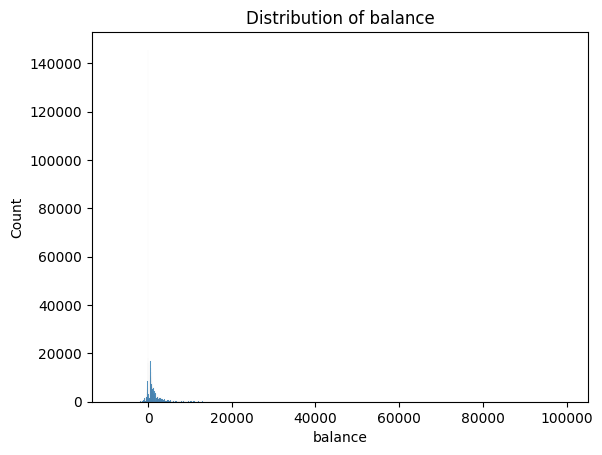

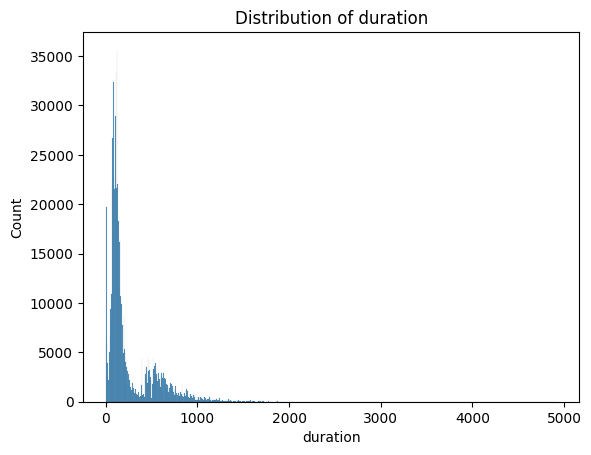

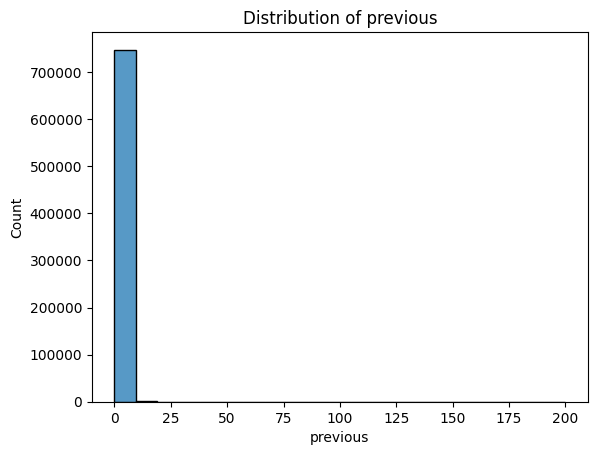

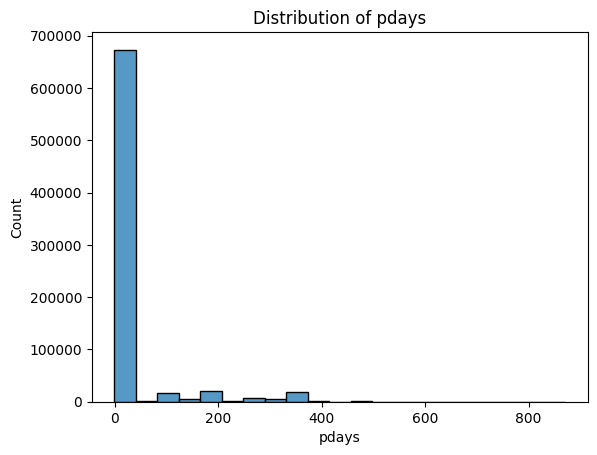

In [12]:
### View Distribution of Continous Variables (look at outliers)
for field in Bank_DF_Train[['balance','duration','previous','pdays']]:

  sns.histplot(
      data = Bank_DF_Train,
      x = f'{field}',
      # binwidth= 100
  )

  plt.title(f"Distribution of {field}")
  plt.show()
  print()

In [13]:
### View Balance amt at 99% quantile
print(np.quantile(Bank_DF_Train['balance'],0.99))
print(np.quantile(Bank_DF_Train['duration'],0.99))
print(np.quantile(Bank_DF_Train['previous'],0.99))
print(np.quantile(Bank_DF_Train['pdays'],0.99))

10861.0
1206.0
6.0
363.0


**<u>Note:</u>**

The average yearly balance field as well as call duration, previous, and pdays all have some extreme values past the 99% quantile of the data that can be smoothed down for the purpose of modeling.

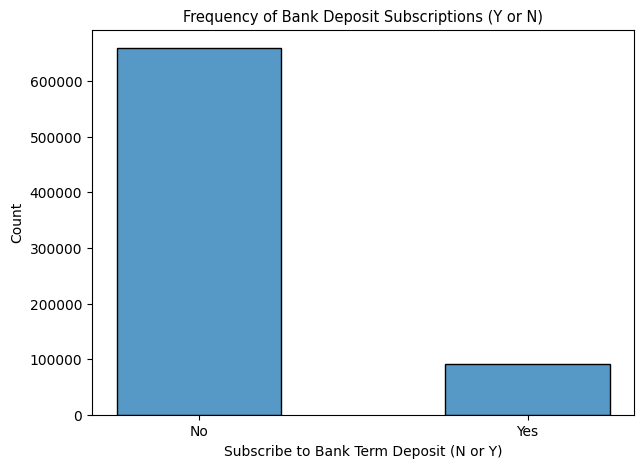

In [14]:
### View Distribution of Target Variable
plt.figure(figsize = (7,5))

sns.histplot(
    data = Bank_DF_Train,
    x = 'y',
    binrange = (np.min(Bank_DF_Train['y']) - 0.5, np.min(Bank_DF_Train['y']) + 1.5),
    binwidth = 1,
    shrink= 0.5
)

plt.xticks([0,1], ['No','Yes'])
plt.xlabel('Subscribe to Bank Term Deposit (N or Y)')
plt.title("Frequency of Bank Deposit Subscriptions (Y or N)", fontsize = 10.5)
plt.show()

**<u>Note:</u>**

We notice a heavy class imbalance in the target variable "y"(subscribe to bank term depost (Y/N).

An imbalance such of this may hurt the model's ability to correctly predict the minority class (in this case, those that did subscribe to a bank term deposit).

To counteract this and improve model performance, we may try a special oversampling method: synthetic minority oversampling technique (SMOTE) that will artificially inject our training set with new, synthetically created instances that are created via linear interpolation between a minority class record and one of its k-nearest neighbors. By doing this, the model wil benefit from having more examples of the minority class to learn from.

In [15]:
### View Nulls in data
Bank_DF_Train.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
month,0


No Nulls in the data.

In [ ]:
### View Duped records in training data
Bank_DF_Train[Bank_DF_Train.duplicated].head()

No duped records in the data.

In [17]:
### Capture all categorical variables
categ = list(Bank_DF_Train.select_dtypes(include = ['object']))
categ.remove("month")

In [18]:
# View unique labels for each categorical variable
for field in Bank_DF_Train[categ]:
  print(field)
  print(Bank_DF_Train[field].unique())

job
['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur'
 'self-employed' 'unknown' 'services' 'retired' 'housemaid' 'unemployed']
marital
['married' 'single' 'divorced']
education
['secondary' 'primary' 'tertiary' 'unknown']
default
['no' 'yes']
housing
['no' 'yes']
loan
['no' 'yes']
contact
['cellular' 'unknown' 'telephone']
poutcome
['unknown' 'other' 'failure' 'success']


We will convert all of these fields to dummy variables for usage in model.

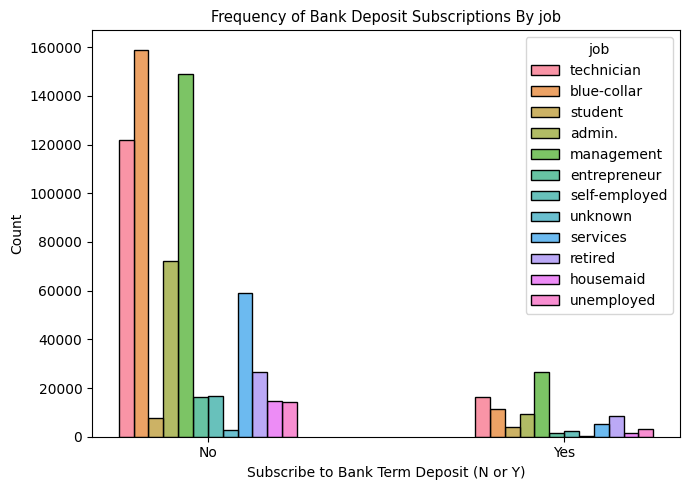

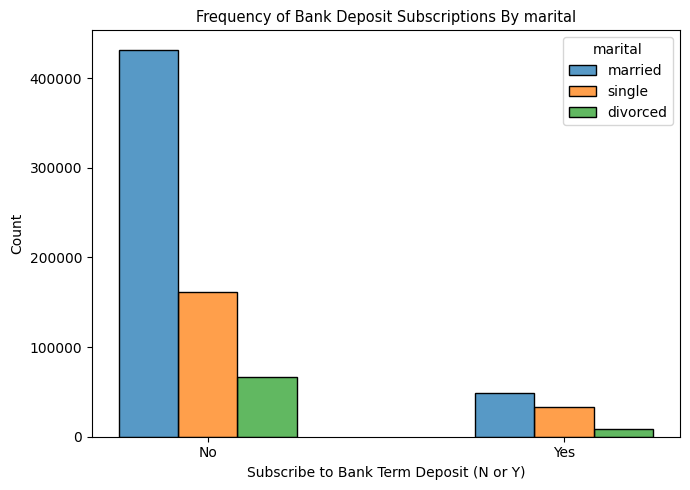

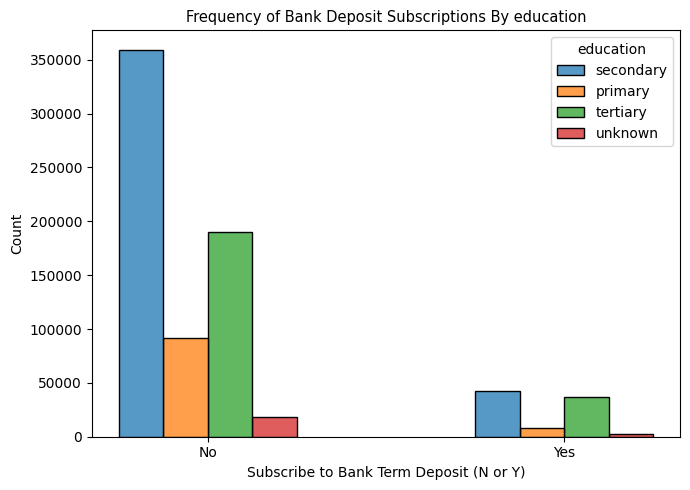

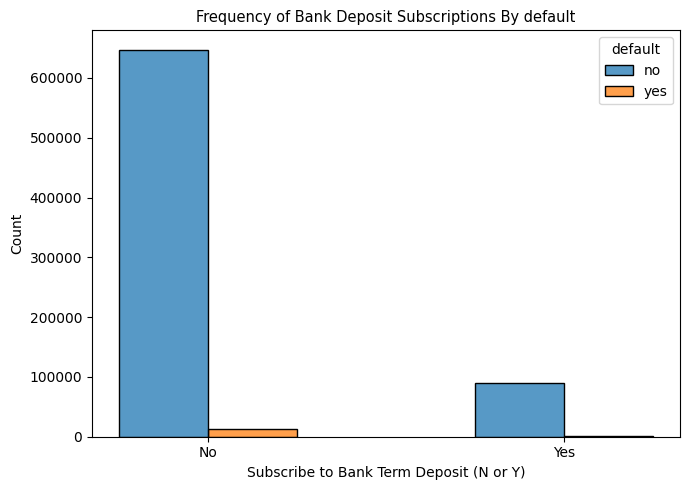

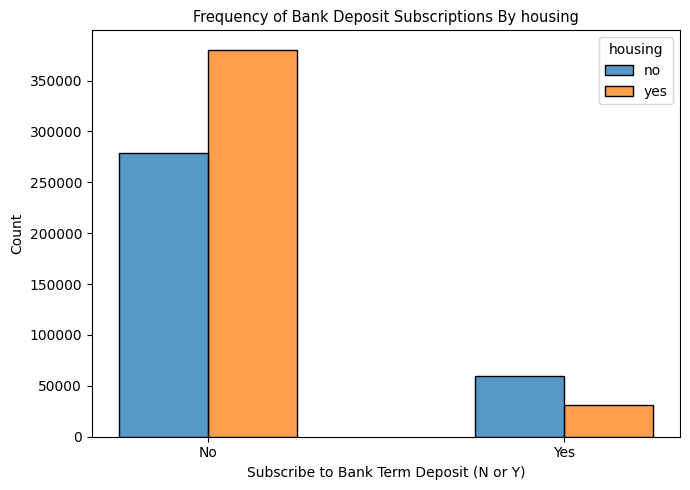

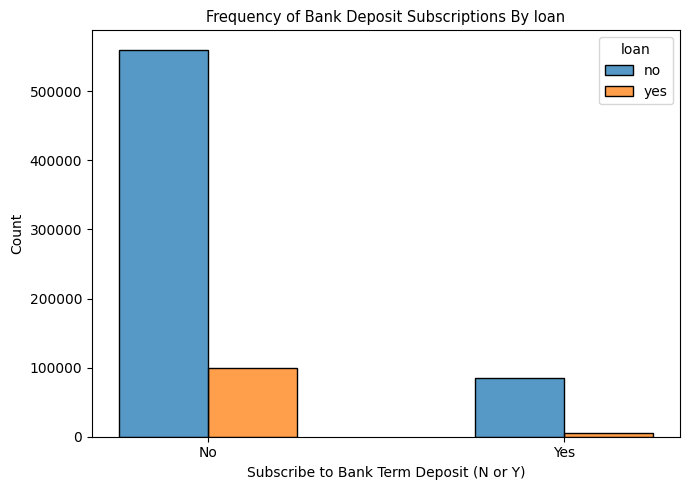

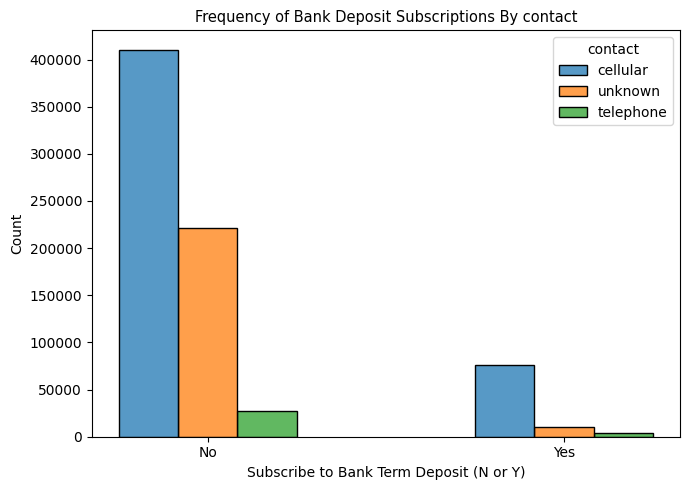

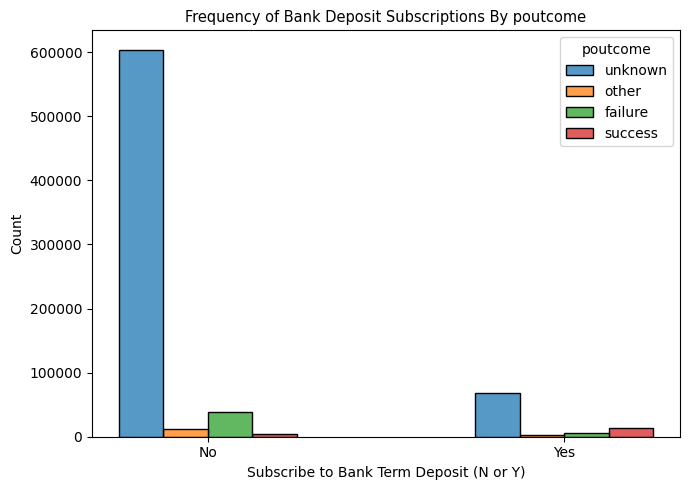

In [19]:
### View Distribution of Target Variable, but by various categories

for field in Bank_DF_Train[categ]:

  plt.figure(figsize = (7,5))

  sns.histplot(
      data = Bank_DF_Train,
      x = 'y',
      binrange = (np.min(Bank_DF_Train['y']) - 0.5, np.min(Bank_DF_Train['y']) + 1.5),
      binwidth = 1,
      shrink= 0.5,
      hue = f'{field}',
      multiple = 'dodge'
  )

  plt.xticks([0,1], ['No','Yes'])
  plt.xlabel('Subscribe to Bank Term Deposit (N or Y)')
  plt.title(f"Frequency of Bank Deposit Subscriptions By {field}", fontsize = 10.5)
  plt.tight_layout()
  plt.show()
  print()

<u>**Notes from above relationships:**</u>

* Interestingly, married individuals made up a majority of the "no's" in terms of whether or not they purchased a term deposit at the bank.

* Blue-Collar workers made up a majority of the "no" class, which is more in line with expectations. Management titled individuals made up a majority of the "yes" class.

* Those who had a already taken out a loan for a house seem more inclined to say no vs those that didn't.

* The vast majority of those that have taken out a personal loan seem not willing to subscribe to the bank's term deposit.

* Those in credit default seem to be very unwilling to subscribe.

* There isn't much known data in terms of the results of previous marketing campaign outcomes per person, but, for the known results, we see that for individuals whose previous campaign had no effect were less inclined to subscribe. Conversely, typically when previous campaigns were successful, the person seems to be a bit more inclined to subscribe.

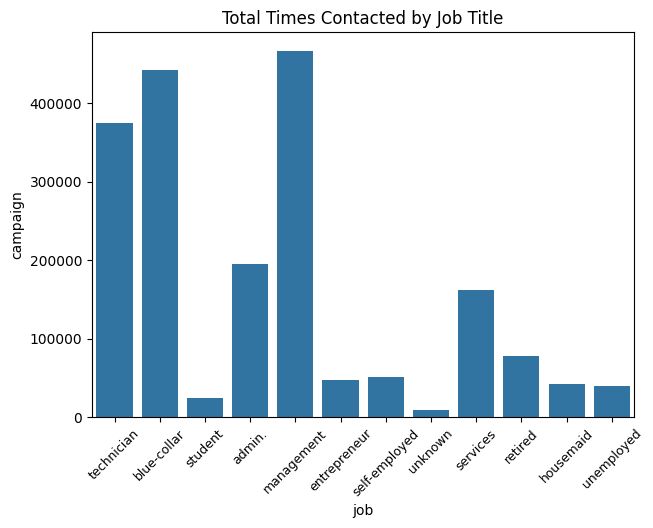

In [20]:
### View Total Campaign Contacts by Contact Medium

plt.figure(figsize = (7,5))

sns.barplot(
    data = Bank_DF_Train,
    x = 'job',
    y = 'campaign',
    estimator= 'sum',
    errorbar= None
)

### Stop using scientific notation on y axis
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation = 45, fontsize = 9)
plt.title("Total Times Contacted by Job Title", fontsize = 12)
plt.show()


Management, Blue-collar, and people with the "technician" job titles were among the most contacted for the bank's campaign.

### Data Prep/Feature Engineering

11/20 to do:

* Smooth out outliers mentioned previously (Done)
* utilize smote technqiue to upsample the data and handle class imbalance (Done)
* Create Dummy Variables from Categorical Vars (Done)
* Create new features (if necessary) (Done)
* Scale Data (Done)
* run basic logisitc reg model on base data
* evaluate using test set
* run again, but on oversampled data
* run an lasso version with K-Folds cross validaiton
* interpret all outputs

#### **Data Prep:**

Prep Data Across Orginal Set, Upsampled Set, and Kaggle Training Set

##### **Removal of outliers:**

In [21]:
### View Balance amt at 99% quantile
print(np.quantile(Bank_DF_Train['balance'],0.99))
print(np.quantile(Bank_DF_Train['duration'],0.99))
print(np.quantile(Bank_DF_Train['previous'],0.99))
print(np.quantile(Bank_DF_Train['pdays'],0.99))

10861.0
1206.0
6.0
363.0


In [22]:
### For all values sitting above the 99% quantile for selected fields, replace those values with the value at the 99% quantile
fields_to_smooth = ['balance','duration','previous','pdays']

for field in Bank_DF_Train[fields_to_smooth]:
  Bank_DF_Train[field] = np.where(Bank_DF_Train[field] > np.quantile(Bank_DF_Train[field],0.99),np.quantile(Bank_DF_Train[field],0.99),Bank_DF_Train[field])

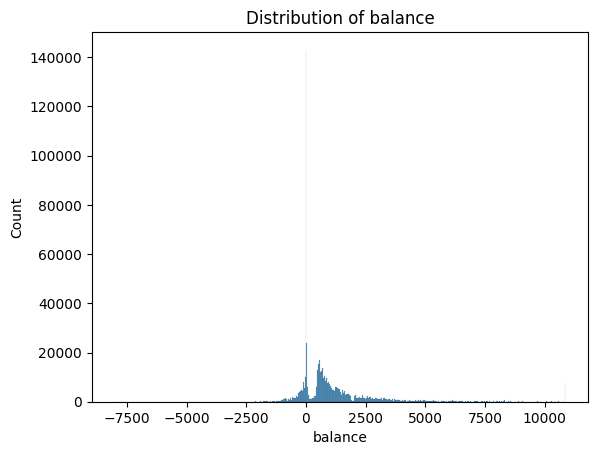

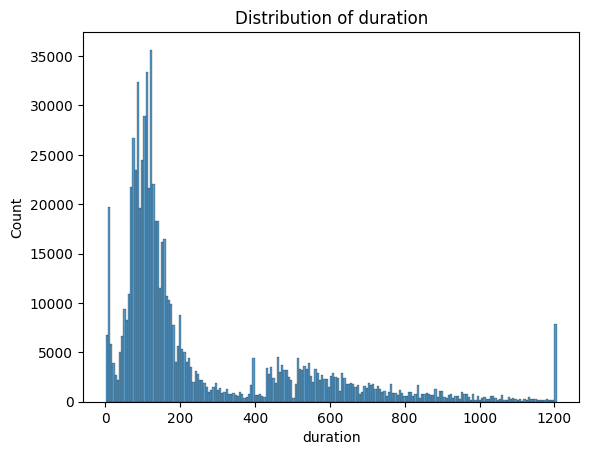

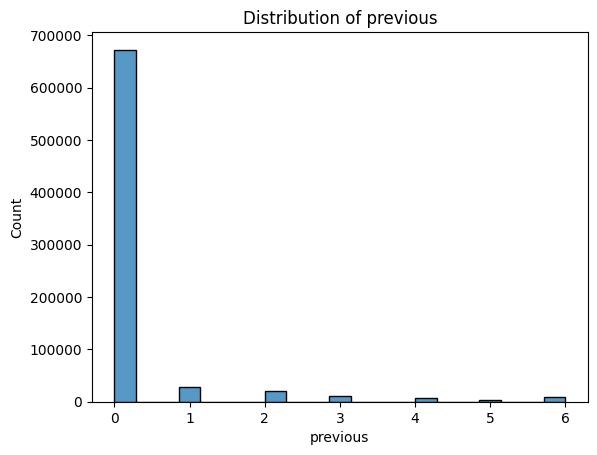

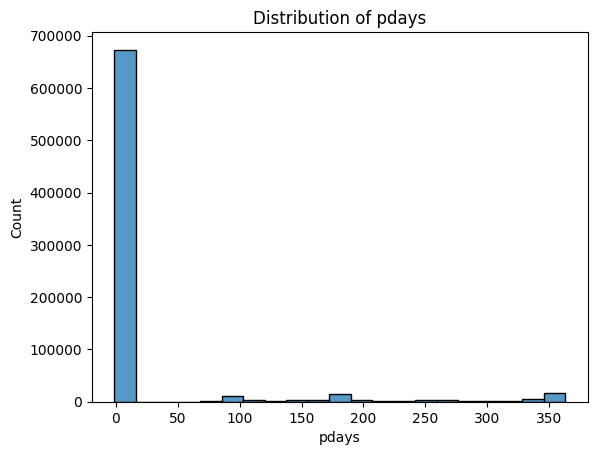

In [23]:
### Check to see if removal of extreme outliers worked
for field in Bank_DF_Train[['balance','duration','previous','pdays']]:

  sns.histplot(
      data = Bank_DF_Train,
      x = f'{field}',
      # binwidth= 100
  )

  plt.title(f"Distribution of {field}")
  plt.show()
  print()

##### **Apply SMOTE Upsampling Method to Training:**

Will not be applied to testing data, as this can result in leakage

In [24]:
### Feature Matrix
X = Bank_DF_Train.drop(columns = 'y')
### Target Variable
Y = Bank_DF_Train['y'].reset_index().drop(columns = ['index']).astype('category')

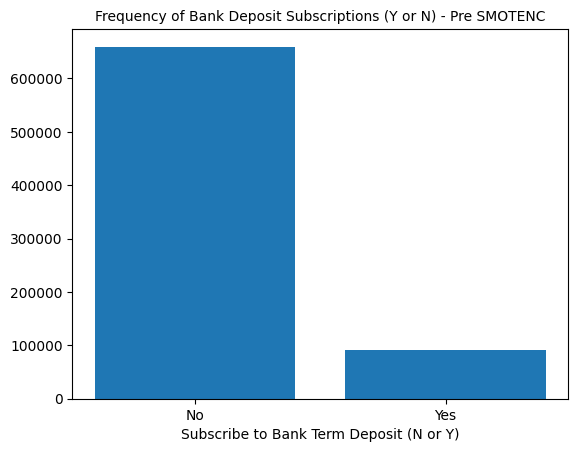

In [25]:
### Distriubtion of Classes before smote
Count_Class = Y['y'].value_counts()

plt.bar(Count_Class.index, Count_Class.values)
plt.xticks([0,1], ['No','Yes'])
plt.xlabel('Subscribe to Bank Term Deposit (N or Y)')
plt.title("Frequency of Bank Deposit Subscriptions (Y or N) - Pre SMOTENC", fontsize = 10)
plt.show()


In [26]:
### Train Test Split (For SMOTE Data)
X_train_smote, X_test_smote , y_train_smote, y_test_smote = train_test_split(X, Y, test_size=0.2, random_state=1) #### 20% of data in test, 80% in train

**<u>Notes:</u>**

We want to ensure that we are only applying SMOTE to the training data, NOT the testing data. SMOTE uses a nearest neigbor technique from each data point to generate synthetic samples, so applying SMOTE before a train test split and then splitting the data after will cause data leakage, as the training data's synthetic samples are already "influenced" by the test set. The testing set would also contain synthetic samples that were influenced by data in the training set. On top of that, oversampled testing data does not represent reality, which is the reason why we test the model on the testing set in the first place.

In [27]:
### Grab categorical column indices
categfields = X_train_smote.select_dtypes(include = ['object']).columns

categorical_indices = [X_train_smote.columns.get_loc(col) for col in categfields]

categorical_indices

[1, 2, 3, 4, 6, 7, 8, 9, 14]

SMOTENC requires categoral columns to be encoded numerically

In [28]:
### Apply ordinal encoding to categorical fields of training data (even if categorical fields aren't ordinal) in order for SMOTENC algorithm to work properly
encoder = OrdinalEncoder()
X_Enc = X_train_smote.copy()
X_Enc[categfields] = encoder.fit_transform(X_train_smote[categfields])

In [29]:
### Apply SMOTENC to training data only (To avoid data leakage)
smote_nc = SMOTENC(categorical_features= categorical_indices, random_state = 42) ### Ensure that we retain the same sample of synthetic fields after each run
X_res, Y_res = smote_nc.fit_resample(X_Enc,y_train_smote)

SMOTE-NC treats categorical columns as unorded categories by using:

* Nearest-neighbor voting
* Mismatch-based distance

When Training and Testing Our Models, we will **NOT** use the smote data for testing, only training, we will use testing data from the non-upsampled, original data.

In [30]:
### Testing Data #### Encode Testing data to ensure label integers allign with training (categories map to each other in same way)
X_test_enc = X_test_smote.copy()
X_test_enc[categfields] = encoder.transform(X_test_smote[categfields])

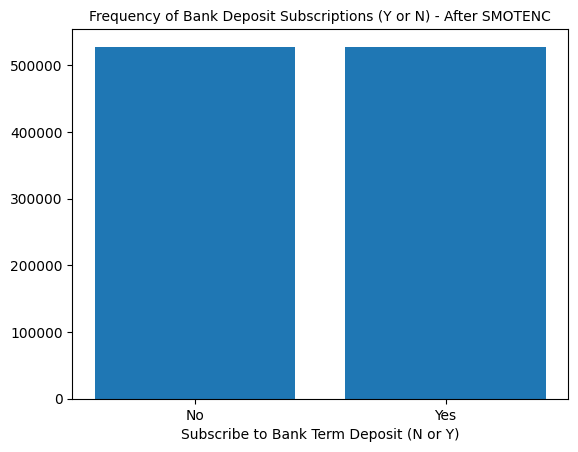

In [68]:
### Distriubtion of Classes after smote
Count_Class = Y_res['y'].value_counts()

plt.bar(Count_Class.index, Count_Class.values)
plt.xticks([0,1], ['No','Yes'])
plt.xlabel('Subscribe to Bank Term Deposit (N or Y)')
plt.title("Frequency of Bank Deposit Subscriptions (Y or N) - After SMOTENC", fontsize = 10)
plt.show()

Classes within our target variable are now evenly balanced.

In [32]:
#### Get labels back in resampled training matrix
X_res[categfields] = encoder.inverse_transform(X_res[categfields])
#### Get labels back in resampled testing matrix
X_test_enc[categfields] = encoder.inverse_transform(X_test_enc[categfields])

In [33]:
### View restored, resampled data
#### Resampled Training Data
print("Training Data")
print(X_res.head(), X_res.shape)
print(Y_res.head(), Y_res.shape)
print()
print("Testing Data")
#### Non-Resampled Testing Data
print(X_test_enc.head(), X_test_enc.shape)
print(y_test_smote.head(), y_test_smote.shape)

Training Data
   age          job  marital  education default  balance housing loan  \
0   31   unemployed   single   tertiary      no  2627.00      no   no   
1   34  blue-collar  married  secondary      no  1221.00     yes   no   
2   32   unemployed   single   tertiary      no  1849.00     yes   no   
3   32       admin.  married  secondary      no   648.00     yes   no   
4   54   management  married  secondary      no  5888.00      no  yes   

    contact month  duration  campaign  pdays  previous poutcome  
0  cellular   apr    110.00         1  -1.00      0.00  unknown  
1  cellular   jul     53.00         2  -1.00      0.00  unknown  
2   unknown   may     48.00         4  -1.00      0.00  unknown  
3   unknown   may    198.00         3  -1.00      0.00  unknown  
4   unknown   jun   1148.00         3  -1.00      0.00  unknown   (1055374, 15)
   y
0  0
1  0
2  0
3  0
4  1 (1055374, 1)

Testing Data
        age          job  marital education default  balance housing loan  \
241

##### **Create Dummy fields:**

Original Design Matrix

In [34]:
### Non-resampled data
X_Categ = X.select_dtypes(include = ['object']).columns

### Create dummies of categ variables
X_Dummies = pd.get_dummies(
    data = X[X_Categ],
    drop_first = True,
    dtype = int
)

### Bring back dummies into original df

X_WDummies = pd.concat([X.drop(columns = X_Categ),X_Dummies], axis = 1)


Kaggle Testing Set

In [35]:
#### Do same with Testing Dataframe from kaggle
Bank_DF_KaggleTest = Bank_DF_Test.drop(columns = ['id','day'])

### Testing Data
X_Categ_KaggleTest = Bank_DF_KaggleTest.select_dtypes(include = ['object']).columns

### Create dummies of categ variables
X_Dummies_KaggleTesting = pd.get_dummies(
    data = Bank_DF_KaggleTest[X_Categ_KaggleTest],
    drop_first = True,
    dtype = int
)

### Bring back dummies into original df

X_WDummies_KaggleTesting= pd.concat([Bank_DF_KaggleTest.drop(columns = X_Categ_KaggleTest),X_Dummies_KaggleTesting], axis = 1)

Resampled Design Matrix:

Training Data:

In [36]:
### resampled data
X_Categ_Res = X_res.select_dtypes(include = ['object']).columns ### Already a list

### Create dummies of categ variables
X_Dummies_Res = pd.get_dummies(
    data = X_res[X_Categ_Res],
    drop_first = True,
    dtype = int
)

### Bring back dummies into original df

X_Res_WDummies = pd.concat([X_res.drop(columns = X_Categ_Res),X_Dummies_Res], axis = 1)

Testing Data:

In [37]:
### resampled data
X_Categ_Res_Testing = X_test_enc.select_dtypes(include = ['object']).columns ### Already a list

### Create dummies of categ variables
X_Dummies_Res_Testing = pd.get_dummies(
    data = X_test_enc[X_Categ_Res_Testing],
    drop_first = True,
    dtype = int
)

### Bring back dummies into original df

X_Res_WDummies_Testing = pd.concat([X_test_enc.drop(columns = X_Categ_Res_Testing),X_Dummies_Res_Testing], axis = 1)

In [38]:
### Original Design Matrix
print(X_WDummies.shape)

### Train/Test Split Desing Matrix
print(X_Res_WDummies.shape)
print(X_Res_WDummies_Testing.shape)

### Kaggle Testing Data
print(X_WDummies_KaggleTesting.shape)

(750000, 41)
(1055374, 41)
(150000, 41)
(250000, 41)


##### Feature Engineering:

Original Feature Matrix

In [39]:
### Center the Age variable to remove large variations in age
X_WDummies['Age_DeMeaned'] = X_WDummies['age'] - X_WDummies['age'].mean()
### Square the De-Meaned Age variable to capture non-linear effects of age on whether a person signed up for a bank term deposit subscription. (Is there a decrease of prob/ at a certain age threshold....)
X_WDummies['Age_DeMeaned_Sqrd'] = X_WDummies['Age_DeMeaned'] ** 2
### Drop Orginal Age Field
X_WDummies.drop(columns = 'age', inplace = True)

Training Set (Kaggle)

In [40]:
### Center the Age variable to remove large variations in age
X_WDummies_KaggleTesting['Age_DeMeaned'] = X_WDummies_KaggleTesting['age'] - X_WDummies_KaggleTesting['age'].mean()
### Square the De-Meaned Age variable to capture non-linear effects of age on whether a person signed up for a bank term deposit subscription. (Is there a decrease of prob/ at a certain age threshold....)
X_WDummies_KaggleTesting['Age_DeMeaned_Sqrd'] = X_WDummies_KaggleTesting['Age_DeMeaned'] ** 2
### Drop Orginal Age Field
X_WDummies_KaggleTesting.drop(columns = 'age', inplace = True)

Upsampled Feature Matrix

Training

In [41]:
### Center the Age variable to remove large variations in age
X_Res_WDummies['Age_DeMeaned'] = X_Res_WDummies['age'] - X_Res_WDummies['age'].mean()
### Square the De-Meaned Age variable to capture non-linear effects of age on whether a person signed up for a bank term deposit subscription. (Is there a decrease of prob/ at a certain age threshold....)
X_Res_WDummies['Age_DeMeaned_Sqrd'] = X_Res_WDummies['Age_DeMeaned'] ** 2
### Drop Orginal Age Field
X_Res_WDummies.drop(columns = 'age', inplace = True)

Testing

In [42]:
### Center the Age variable to remove large variations in age
X_Res_WDummies_Testing['Age_DeMeaned'] = X_Res_WDummies_Testing['age'] - X_Res_WDummies_Testing['age'].mean()
### Square the De-Meaned Age variable to capture non-linear effects of age on whether a person signed up for a bank term deposit subscription. (Is there a decrease of prob/ at a certain age threshold....)
X_Res_WDummies_Testing['Age_DeMeaned_Sqrd'] = X_Res_WDummies_Testing['Age_DeMeaned'] ** 2
### Drop Orginal Age Field
X_Res_WDummies_Testing.drop(columns = 'age', inplace = True)

##### Variable Scaling



Original Design Matrix

In [43]:
### Set Scaler Object
Scaler_Orig = StandardScaler()
### Select All non-dummy variables
Non_Dummy = ['balance','duration','campaign','pdays','previous','Age_DeMeaned','Age_DeMeaned_Sqrd']
### Apply standard scaling to non-dummy variables
X_Scaled_Vars = Scaler_Orig.fit_transform(X_WDummies[Non_Dummy])
### Convert Numpy Array Back to DF
X_Scaled_Vars_DF = pd.DataFrame(X_Scaled_Vars, columns = X_WDummies[Non_Dummy].columns)
### Merge Scaled Vars with Dummy Fields
X_Scaled_DF_Final = pd.concat([X_Scaled_Vars_DF,X_WDummies.drop(columns = Non_Dummy)], axis = 1)

Kaggle Testing Data

In [44]:
### Set Scaler Object
Scaler_Kaggle = StandardScaler()
### Select All non-dummy variables
Non_Dummy = ['balance','duration','campaign','pdays','previous','Age_DeMeaned','Age_DeMeaned_Sqrd']
### Apply standard scaling to non-dummy variables
X_Scaled_Vars_KaggleTesting = Scaler_Kaggle.fit_transform(X_WDummies_KaggleTesting[Non_Dummy])
### Convert Numpy Array Back to DF
X_Scaled_Vars_KaggleTesting_DF = pd.DataFrame(X_Scaled_Vars_KaggleTesting, columns = X_WDummies_KaggleTesting[Non_Dummy].columns)
### Merge Scaled Vars with Dummy Fields
X_Scaled_DF_Final_KaggleTesting = pd.concat([X_Scaled_Vars_KaggleTesting_DF,X_WDummies_KaggleTesting.drop(columns = Non_Dummy)], axis = 1)

Upsampled Design Matrix

Training & Testing

In [45]:
### Set Scaler Object (Want to fit scalar once on the testing set to ensure that training and testing have the same scale)
Scaler_Upsampled = StandardScaler()
### Select All non-dummy variables
Non_Dummy = ['balance','duration','campaign','pdays','previous','Age_DeMeaned','Age_DeMeaned_Sqrd']
### Apply standard scaling to non-dummy variables
X_Scaled_Vars_Res = Scaler_Upsampled.fit_transform(X_Res_WDummies[Non_Dummy])
### Convert Numpy Array Back to DF
X_Scaled_Vars_Res_DF = pd.DataFrame(X_Scaled_Vars_Res, columns = X_Res_WDummies[Non_Dummy].columns, index = X_Res_WDummies.index)
### Merge Scaled Vars with Dummy Fields
X_Res_Scaled_DF_Final = pd.concat([X_Scaled_Vars_Res_DF,X_Res_WDummies.drop(columns = Non_Dummy)], axis = 1)


### Apply standard scaling to non-dummy variables (based on fit from training data)
X_Scaled_Vars_Res_Testing = Scaler_Upsampled.transform(X_Res_WDummies_Testing[Non_Dummy])
# ### Convert Numpy Array Back to DF
X_Scaled_Vars_Res_Testing_DF = pd.DataFrame(X_Scaled_Vars_Res_Testing, columns = X_Res_WDummies_Testing[Non_Dummy].columns, index = X_Res_WDummies_Testing.index)
##### Dummy fields
X_Scaled_Vars_Dummies = X_Res_WDummies_Testing.drop(columns = Non_Dummy)
### Merge Scaled Vars with Dummy Fields
X_Res_Scaled_Testing_DF_Final = pd.concat([X_Scaled_Vars_Res_Testing_DF,X_Scaled_Vars_Dummies], axis = 1)

In [46]:
### Original Design Matrix
print(X_Scaled_DF_Final.shape)

### Train/Test Split Desing Matrix
print(X_Res_Scaled_DF_Final.shape)
print(X_Res_Scaled_Testing_DF_Final.shape)

### Kaggle Testing Data
print(X_Scaled_DF_Final_KaggleTesting.shape)

(750000, 42)
(1055374, 42)
(150000, 42)
(250000, 42)


### Modeling

#### Simple Logistic Regression (No Upsampling):

Split Data in Test and Training

In [47]:
### Train Test Split
X_train, X_test , y_train, y_test = train_test_split(X_Scaled_DF_Final, Y, test_size=0.2, random_state=1) #### 20% of data in test, 80% in train

In [48]:
### Fit logistic Regression on Original Data
logistic_Orginal = sm.Logit(y_train,sm.add_constant(X_train))
logistic_Orginal = logistic_Orginal.fit()

print(logistic_Orginal.summary())

Optimization terminated successfully.
         Current function value: 0.193319
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599957
Method:                           MLE   Df Model:                           42
Date:                Sun, 23 Nov 2025   Pseudo R-squ.:                  0.4746
Time:                        22:05:08   Log-Likelihood:            -1.1599e+05
converged:                       True   LL-Null:                   -2.2078e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.1144      0.056    -20.052      0.000      -1.223      -1.006
ba

**<u>Notes</u>:**

All features except for: poutcome_other, marital_married, job_retired, and education unknown are showing statistically significant coefficients in association with whether or not a client subcribed to a bank term deposit.

Pseudo R2 of 47.46% indicates nearly half the variation is being explained by the model.

Coefficient Interpretations:

* **Age_DeMeaned:** The coefficeint for De-Meaned Age is -0.1114. This is interpreted as (due to scaling): "for every 1 standard deviation change in De-Meaned Age, the log odds of a client subscribing to a bank term deposit decreases by 0.1114". That equates to a decrease in the odds of subscribing by a factor of 0.89x (-10.54%) for every 1 standard devation increase in Age_DeMeaned. From a linear stanpoint, as age increases, the probability of a client subscribing decreases.

* **Age_DeMeaned_Sqrd:** The coefficeint for squared De-Meaned Age is 0.1684. This is essentially telling us that the effect of age on the probability of subscribing is curved. Up to some threshhold, increasing age leads to a decrease in the probability of subscribing, but then when that threshold is hit, the probability starts to increase.


* **balance:** The coefficeint for average yearly balance is 0.1511. This is interpreted as (due to scaling): "for every 1 standard deviation change in Average Yearly balance, the log odds of a client subscribing to a bank term deposit increases by 0.1511". That equates to an increase in the odds of subscribing by a factor of 1.16x (+16%) for every 1 standard devation increase in balance.       

* **marital_single:** The Coefficient (unscaled) is 0.1795. The base category being compared to is "marital_divorced". This is interpreted as: "for single clients, all else held equal, the log odds of subscribing to a bank term deposit increases by 0.1795 compared to divorced clients." That equates to an increase in the odds of subscribing by a factor of 1.196x (+19.6%) for single clients vs divorced clients.          

* **month_jan:** Interestingly, the coefficient here is -1.2134 (unscaled).This is interpreted as: "for clients who's last contact month was in Jan (compared to a baseline of April), the log odds of a client subscribing to a bank term deposit decreased by 1.2134". That equates to a decrease in the odds of subscribing by a factor of 0.30x (-70.28%)      

##### Model Evaluation:


In [49]:
### Get Predictions using test data set
p_x = logistic_Orginal.predict(sm.add_constant(X_test))
y_hat = (p_x > 0.5) ### Set threshold to 0.5

conf_mat = pd.crosstab(y_test['y'], y_hat, rownames=['Actual Subscriptions'], colnames=['Predicted Subscriptions'])
# Add row and column sums
conf_mat.loc['Column_Total']= conf_mat.sum(numeric_only=True, axis=0)
conf_mat.loc[:,'Row_Total'] = conf_mat.sum(numeric_only=True, axis=1)
print(conf_mat)

Predicted Subscriptions   False   True  Row_Total
Actual Subscriptions                             
0                        127993   3832     131825
1                          8760   9415      18175
Column_Total             136753  13247     150000


In [50]:
### Confusion Matrix Key Metrics at 0.5 cuttoff
FN = 8760
FP = 3832
TN = 127993
TP = 9415
Tot_Positives = FN + TP
Tot_Negatives = FP + TN
N_Plus_P = Tot_Positives + Tot_Negatives

MCR = (FP + FN)/N_Plus_P
TPR = TP/Tot_Positives  ### Out of all positive cases (FN and TP), what % where accurately labeled positive
TNR = TN/Tot_Negatives
precision = TP/(TP + FP) ### Out of all cases labeled Positive (TP and FP) what % were accurately labeled positive

print(f"The Misclassified Rate is: {MCR * 100:.2f}%")
print(f"The True Positive Rate (Sensitivity or Recall) is: {TPR * 100:.2f}%")
print(f"The True Negative Rate (Specifity) is: {TNR * 100:.2f}%")
print(f"The Precision is: {precision * 100:.2f}%")

The Misclassified Rate is: 8.39%
The True Positive Rate (Sensitivity or Recall) is: 51.80%
The True Negative Rate (Specifity) is: 97.09%
The Precision is: 71.07%


**<u>Notes:</u>**

This model is excellent at predicting the negative class (TNR of 97.09%) which is the majority of records. The True Positive Rate only sits at 51%, however, which is a sign that the imbalance of classes is effecting the models ability to recognize cases where a client subscribed.

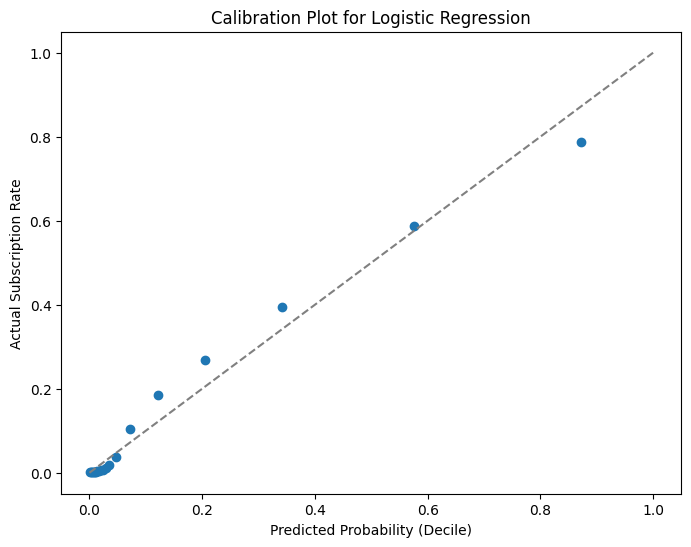

In [51]:
### Calibration Plot
y_test_calib = y_test.copy()
y_test_calib['P_Subscribe'] = logistic_Orginal.predict(sm.add_constant(X_test))
y_test_calib['decile'] = pd.qcut(y_test_calib['P_Subscribe'], 20, labels=False) ### 20 is the total decile groups created (segments) (qcut creats quanitle-based bins)

# Calculate the average predicted probability and actual default rate for each decile
y_test_calib['y'] = y_test_calib['y'].astype('int')
decile_stats = y_test_calib.groupby('decile').agg({'P_Subscribe': 'mean', 'y': 'mean'})

# Scatterplot of predicted probabilities vs actual default rates
plt.figure(figsize=(8, 6))
plt.scatter(decile_stats['P_Subscribe'], decile_stats['y'])
plt.xlabel('Predicted Probability (Decile)')
plt.ylabel('Actual Subscription Rate')
plt.title('Calibration Plot for Logistic Regression')

# Add a line with slope 1
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.show()

**<u>Notes</u>:**

Calibration Plot is generated to show how well the predicted probabilities allign with actual outcomes. Deciles are generally following the line quite well, with minimal separation. You can also see how a bulk of the predicited deciles fall near 0, are closely clustered, and fit almost perfectly on the line. As we move up the decile bins, we see that the predicted values begin to deviate more from the actuals (and move farther away from the line). This increase in noise as we move up the line highlights our class imbalance in the target variable (0 dominant).

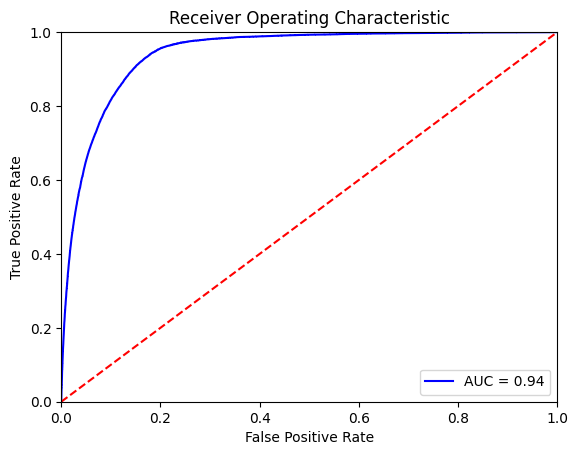

In [93]:
### Show ROC Curve at Various Thresholds
fpr, tpr, threshold = roc_curve(y_test['y'], p_x)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**<u>Notes:</u>**

We see generally as the false positive rate increases (due to us lowering our classification threshold), we generally get a good bump in our true positive rate as we move through the curve. The total area under the curve sits at 0.94. Overall, this is an indicator that our model is doing a great job at separating between both classes (1/0). This means that in most cases, the model assigns higher scores to positive cases than to negative ones. Our class imbalance could potentially be playing a role here, as the model may be sensitive to any observation who's characteristics may not directly follow the characteristics of someone that's in the 0 class, so they get assigned a high enough probability that has them ending up in the positive class for a given threshold.

In [94]:
### Find the optimal classification threshold
# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr  ### Sensitivity - Specificity

# Find the optimal threshold (maximizing Youden's J)
optimal_idx = np.argmax(youden_j) ### Prints the index of the maximum value in the array
optimal_threshold = threshold[optimal_idx]

# Print results
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Youden's J Statistic: {youden_j[optimal_idx]}")

Optimal Threshold: 0.07160716336105291
Youden's J Statistic: 0.7610982840355385


In [99]:
youden_j[optimal_idx]

np.float64(0.7610982840355385)

We see that we can set our cuttoff threshold to 0.0716 (label anything above that threshold a 1). I think this is occuring because of the class imbalance we are seeing. We are really good at prediciting the majority class (0), so it does not take a very high probability assignment in order for a prediction to be classified as "1".

Confusion Matrix for optimal threshold:

In [54]:
### Get Predictions using test data set
p_x = logistic_Orginal.predict(sm.add_constant(X_test))
y_hat = (p_x > optimal_threshold) ### Set threshold to 0.0716

conf_mat = pd.crosstab(y_test['y'], y_hat, rownames=['Actual Subscriptions'], colnames=['Predicted Subscriptions'])
# Add row and column sums
conf_mat.loc['Column_Total']= conf_mat.sum(numeric_only=True, axis=0)
conf_mat.loc[:,'Row_Total'] = conf_mat.sum(numeric_only=True, axis=1)
print(conf_mat)

Predicted Subscriptions   False   True  Row_Total
Actual Subscriptions                             
0                        107875  23950     131825
1                          1041  17134      18175
Column_Total             108916  41084     150000


In [55]:
FN = 1041
FP = 23950
TN = 107875
TP = 17134
Tot_Positives = FN + TP
Tot_Negatives = FP + TN
N_Plus_P = Tot_Positives + Tot_Negatives

MCR = (FP + FN)/N_Plus_P
TPR = TP/Tot_Positives  ### Out of all positive cases (FN and TP), what % where accurately labeled positive
TNR = TN/Tot_Negatives
precision = TP/(TP + FP) ### Out of all cases labeled Positive (TP and FP) what % were accurately labeled positive

print(f"The Misclassified Rate is: {MCR * 100:.2f}%")
print(f"The True Positive Rate (Sensitivity or Recall) is: {TPR * 100:.2f}%")
print(f"The True Negative Rate (Specifity) is: {TNR * 100:.2f}%")
print(f"The Precision is: {precision * 100:.2f}%")

The Misclassified Rate is: 16.66%
The True Positive Rate (Sensitivity or Recall) is: 94.27%
The True Negative Rate (Specifity) is: 81.83%
The Precision is: 41.70%


**<u>Notes:</u>**

We see that after applying the optimal cutoff threshold, our TPR sky rockets (94.27% vs 51%). To couple with that, our Precision dips from 71.07% to 41.7%, which is expected given our threshold is so close to just being 0. Our True Negative rate suffers a bit from the low threshold (dipping from 97% to 81%).

#### Simple Logisitic Regression (SMOTENC Upscaling):

In [56]:
### Upsampled Training and Testing Data
### No need to split the Upsampled Data into Train and Test, we will use the full upsampled dataset for training, then will use the testing set generated from the non-upscaled data for testing.
### Train
X_train_Res = X_Res_Scaled_DF_Final
y_train_Res = Y_res
### Test
X_test_NoUpsamp = X_Res_Scaled_Testing_DF_Final ### Not upsampled
y_test_NoUpsam = y_test_smote ### Not upsampled


In [57]:
### Fit logistic Regression on Original Data
logistic_Upscaled = sm.Logit(y_train_Res,sm.add_constant(X_train_Res))
logistic_Upscaled = logistic_Upscaled.fit()

print(logistic_Upscaled.summary())

Optimization terminated successfully.
         Current function value: 0.269626
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              1055374
Model:                          Logit   Df Residuals:                  1055331
Method:                           MLE   Df Model:                           42
Date:                Sun, 23 Nov 2025   Pseudo R-squ.:                  0.6110
Time:                        22:05:21   Log-Likelihood:            -2.8456e+05
converged:                       True   LL-Null:                   -7.3153e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8893      0.038     23.310      0.000       0.815       0.964
ba

**<u>Notes:</u>**

Immediatly, we see a significant boost to Psudeo R2 (0.6110) in this upsampled model vs the original: 0.4746

The loglikelihood estimate is much smaller in this model (-2.8456e+05) vs the non-upsampled model. This typically indicates a worse fit, but this a lowered Likelihood estimate is typical when applying SMOTE and creating synthetic records in the data, so a better evaluation for this model will ultimately be the Confusion matrix and ROC Curve.

##### Model Evaluation:

In [58]:
### Get Predictions using test data set
p_x_res = logistic_Upscaled.predict(sm.add_constant(X_test_NoUpsamp))
y_hat_res = (p_x_res > 0.5) ### Set threshold to 0.5

conf_mat_res = pd.crosstab(y_test_NoUpsam['y'], y_hat_res, rownames=['Actual Subscriptions'], colnames=['Predicted Subscriptions'])
# Add row and column sums
conf_mat_res.loc['Column_Total']= conf_mat_res.sum(numeric_only=True, axis=0)
conf_mat_res.loc[:,'Row_Total'] = conf_mat_res.sum(numeric_only=True, axis=1)
print(conf_mat_res)

Predicted Subscriptions   False   True  Row_Total
Actual Subscriptions                             
0                        116619  15206     131825
1                          2918  15257      18175
Column_Total             119537  30463     150000


In [59]:
### Confusion Matrix Key Metrics at 0.5 cuttoff
FN = 2918
FP = 15206
TN = 116619
TP = 15257
Tot_Positives = FN + TP
Tot_Negatives = FP + TN
N_Plus_P = Tot_Positives + Tot_Negatives

MCR = (FP + FN)/N_Plus_P
TPR = TP/Tot_Positives  ### Out of all positive cases (FN and TP), what % where accurately labeled positive
TNR = TN/Tot_Negatives
precision = TP/(TP + FP) ### Out of all cases labeled Positive (TP and FP) what % were accurately labeled positive

print(f"The Misclassified Rate is: {MCR * 100:.2f}%")
print(f"The True Positive Rate (Sensitivity or Recall) is: {TPR * 100:.2f}%")
print(f"The True Negative Rate (Specifity) is: {TNR * 100:.2f}%")
print(f"The Precision is: {precision * 100:.2f}%")

The Misclassified Rate is: 12.08%
The True Positive Rate (Sensitivity or Recall) is: 83.94%
The True Negative Rate (Specifity) is: 88.47%
The Precision is: 50.08%


**<u>Notes:</u>**

The effect of SMOTE was substantial in terms of recogzing the positive class. Our TPR now sits at 83.94%, which greatly outperforms our non-upsampled model (51.80%). The TNR took a dip (88.47% vs 97.09%). Both of these values are further explained by our lower precision of 50.08% (vs 71% in the upsampled model): Now, The model is not biased to the negative class, and because it has many positive class cases to learn from, it is able to capture many more true positive cases, but at the expense of misclassifying negative cases as positives more frequently.

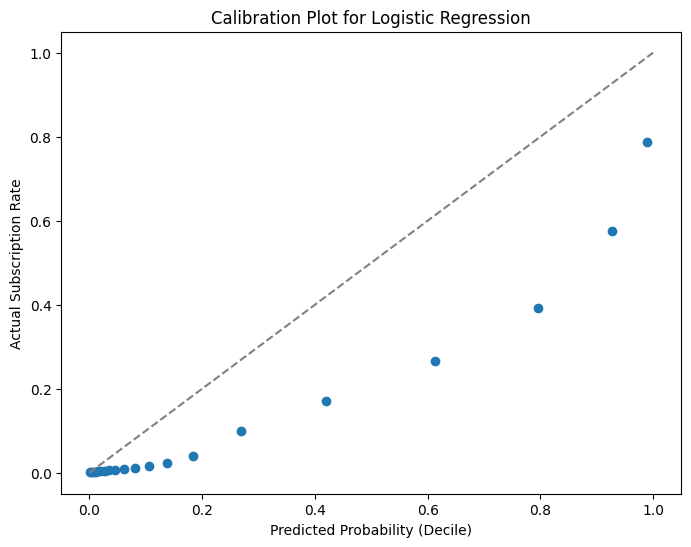

In [60]:
### Calibration Plot
y_test_res_calib = y_test_NoUpsam.copy()
y_test_res_calib['P_Subscribe'] = logistic_Upscaled.predict(sm.add_constant(X_test_NoUpsamp))
y_test_res_calib['decile'] = pd.qcut(y_test_res_calib['P_Subscribe'], 20, labels=False) ### 20 is the total decile groups created (segments) (qcut creats quanitle-based bins)

# Calculate the average predicted probability and actual subscription rate for each decile
y_test_res_calib['y'] = y_test_res_calib['y'].astype('int')
decile_stats_res = y_test_res_calib.groupby('decile').agg({'P_Subscribe': 'mean', 'y': 'mean'})

# Scatterplot of predicted probabilities vs actual Subscription rates
plt.figure(figsize=(8, 6))
plt.scatter(decile_stats_res['P_Subscribe'], decile_stats_res['y'])
plt.xlabel('Predicted Probability (Decile)')
plt.ylabel('Actual Subscription Rate')
plt.title('Calibration Plot for Logistic Regression')

# Add a line with slope 1
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.show()

**<u>Notes:</u>**

We now notice how the calibration plot is now forming a curve under the diagonal line. This is to be expected when using a SMOTE technique such as this. The oversampled data is going to be overly confident versus the original data when identifiying the positive class, given that the original data had a heavy class imbalance towards the negative class. We see that early points are at or near 0 when looking at the lower probability decile, but as we move to higher predicted probabilites, and towards the positive class, we see the spread between predicted and acutal increase, highlighting the increased amount of optimism in predicting the positive class due to oversampling. These higher probabilities put certain observations over our cutoff threshold for the postive class that otherwise would not be caputured using the non-upsampled data, leading to the substantial increase in our TPR coupled with our higher misclassification rate (most likely edge cases that could go either way).

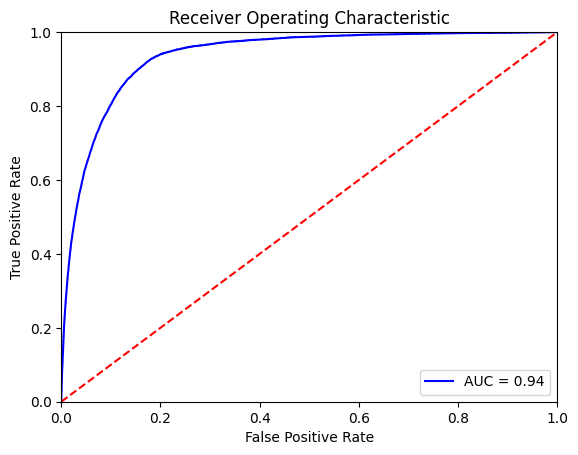

In [61]:
### Show ROC Curve at Various Thresholds
fpr, tpr, threshold = roc_curve(y_test_NoUpsam['y'], p_x_res)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**<u>Notes:</u>**

The AUC remains the same as the non-upsampled model (0.94), indicating that this upsampled model is just as efficient at distinguishing between the positive and negative classes. As we trace along the curve, we see that we can attain a very high TPR relative to a low FPR early on given some threshold.

In [62]:
### Find the optimal classification threshold
# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr  ### Sensitivity - Specificity

# Find the optimal threshold (maximizing Youden's J)
optimal_idx = np.argmax(youden_j) ### Prints the index of the maximum value in the array
optimal_threshold = threshold[optimal_idx]

# Print results
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Youden's J Statistic: {youden_j[optimal_idx]}")

Optimal Threshold: 0.29586270160674993
Youden's J Statistic: 0.7465803184633456


Confusion Matrix Given Optimal Cuttoff Value:

In [63]:
### Optimal Confusion Matrix

### Get Predictions using test data set
p_x_res = logistic_Upscaled.predict(sm.add_constant(X_test_NoUpsamp))
y_hat_res = (p_x_res > optimal_threshold) ### Set threshold to 0.5

conf_mat_res = pd.crosstab(y_test_NoUpsam['y'], y_hat_res, rownames=['Actual Subscriptions'], colnames=['Predicted Subscriptions'])
# Add row and column sums
conf_mat_res.loc['Column_Total']= conf_mat_res.sum(numeric_only=True, axis=0)
conf_mat_res.loc[:,'Row_Total'] = conf_mat_res.sum(numeric_only=True, axis=1)
print(conf_mat_res)

Predicted Subscriptions   False   True  Row_Total
Actual Subscriptions                             
0                        109080  22745     131825
1                          1471  16704      18175
Column_Total             110551  39449     150000


In [64]:
### Optimal Confusion Matrix

### Confusion Matrix Key Metrics at 0.5 cuttoff
FN = 1471
FP = 22745
TN = 109080
TP = 16704
Tot_Positives = FN + TP
Tot_Negatives = FP + TN
N_Plus_P = Tot_Positives + Tot_Negatives

MCR = (FP + FN)/N_Plus_P
TPR = TP/Tot_Positives  ### Out of all positive cases (FN and TP), what % where accurately labeled positive
TNR = TN/Tot_Negatives
precision = TP/(TP + FP) ### Out of all cases labeled Positive (TP and FP) what % were accurately labeled positive

print(f"The Misclassified Rate is: {MCR * 100:.2f}%")
print(f"The True Positive Rate (Sensitivity or Recall) is: {TPR * 100:.2f}%")
print(f"The True Negative Rate (Specifity) is: {TNR * 100:.2f}%")
print(f"The Precision is: {precision * 100:.2f}%")

The Misclassified Rate is: 16.14%
The True Positive Rate (Sensitivity or Recall) is: 91.91%
The True Negative Rate (Specifity) is: 82.75%
The Precision is: 42.34%


##### **Final Notes on Simple Models:**

Both the non-upsampled and upsampled models do a great job of distinguishing amongst the positive and negative classes, as indicated by AUCs of 0.94. Where upsampling/SMOTE greatly helped, was in the model's ability to accuratly identify the positive classes (TPR of 83.94% for the upsampled model vs only 51.80% TPR for the non-upsampled model assuming a 50% Threshold). It is noted that the TNR (88.47% for the Upsampled model vs 97.09% TNR for the non-upsampled model) decreased due to the increased model confidence in predicting the positive class. This is the tradeoff of upsampling, but cutoff points for the positive class can be set to adjust on a case by case basis.

Another note, is that after upsampling, the optimal cuttoff threshold increased from 0.07 to 0.296, which is an indication that the upsampled model may be over predicting the positive class vs the non-upsampled model. Since the upsampled model had more examples of the positive class to learn from, this "over confidence" is expected. The downside here, as previously mentioned, is that we get more false positives as an expense of predicting far more positive cases correctly, but this optimal threshold serves as a way of compensating for the model's over confidence, in case we don't want to sacrifice our accuracy for higher true positive rates.

I recommend we select the SMOTE-enhanced model when picking between the two with the caveat that we recognize that what we gain in the increased Recall rate, we lose in overall accuracy, so our cutt-off thresholds should be adjusted accordingly on a situational basis.

#### Lasso Logistic Regression on SMOTENC Data With KFolds CV:


Utilizing SKlearn's LogisticRegressionCV:

In logistic regression, the regularization strength is controlled by the parameter C (inverse of regularization parameter λ in ridge/lasso terms).

* Smaller C : stronger regularization (more penalty, simpler model).
* Larger C : weaker regularization (less penalty, more complex model).

In [65]:
### Testing different penalty values
np.logspace(-5,4,25) ### on a log scale (base 10), start and stop points are exponents (Spacings are even in the exponents)

array([1.00000000e-05, 2.37137371e-05, 5.62341325e-05, 1.33352143e-04,
       3.16227766e-04, 7.49894209e-04, 1.77827941e-03, 4.21696503e-03,
       1.00000000e-02, 2.37137371e-02, 5.62341325e-02, 1.33352143e-01,
       3.16227766e-01, 7.49894209e-01, 1.77827941e+00, 4.21696503e+00,
       1.00000000e+01, 2.37137371e+01, 5.62341325e+01, 1.33352143e+02,
       3.16227766e+02, 7.49894209e+02, 1.77827941e+03, 4.21696503e+03,
       1.00000000e+04])

In [66]:
### Penalty Tuning Parameters
alphas = np.logspace(-5,4,25)

In [69]:
# Create a logistic regression model with L1 penalty and cross-validation
### 5 Cross Validation folds, testing on 10 evenly spaced values for the inverse of the penalty parameter (even spaced)
Lasso_logistic = LogisticRegressionCV(cv=5, Cs= alphas, penalty='l1', solver='saga', max_iter=10000, random_state = 42).fit(X_train_Res,y_train_Res['y'])  ### 25 alphas * 5 folds = 125 fits
# Using saga lover for faster performance
# Took 31 Minutes to run with Cs = np.logspace(-5,4,25)
# Get the best model (with optimal penalty)
best_Lasso_Model = Lasso_logistic

In [70]:
# Print the coefficients of the best model
count = 0
print("Coefficients of the best Lasso model:")
for feature, coef in zip(X_train_Res.columns, best_Lasso_Model.coef_[0]):
  count = count + 1
  print(f"{feature}: {coef}")

print(f"Total Features = {count}")

Coefficients of the best Lasso model:
balance: 0.15509406398894762
duration: 2.487481532878128
campaign: -0.5893347320138689
pdays: -0.33108799673890466
previous: 0.09518095025254922
Age_DeMeaned: -0.13320430804295658
Age_DeMeaned_Sqrd: 0.15466073452263934
job_blue-collar: -0.36837441849614816
job_entrepreneur: -1.5415409975683023
job_housemaid: -1.4071891948987858
job_management: 0.16505057908462578
job_retired: 0.46528251508667207
job_self-employed: -1.1887989850578322
job_services: -0.6559123849154139
job_student: 0.4608387428249105
job_technician: -0.09409678613210407
job_unemployed: -1.15803913185017
job_unknown: -1.3084549464067128
marital_married: 0.612501462602122
marital_single: 0.7206846738276873
education_secondary: 0.6559551012363232
education_tertiary: 0.6626579978868434
education_unknown: -0.7261143031773164
default_yes: -0.16540943535653485
housing_yes: -1.1494048272237891
loan_yes: -1.4850472230664746
contact_telephone: -1.1748167898962902
contact_unknown: -2.1080993369

In [71]:
#### Get Coefficients from Lasso and regular Logistic Regression Models in Dataframe
Coeff_DF_Lasso = pd.DataFrame(best_Lasso_Model.coef_[0], index = X_train_Res.columns).rename(columns = {0 : 'Coefficient_Lasso'})
Coeff_DF_Log = pd.DataFrame(data = logistic_Upscaled.params[1:], index = logistic_Upscaled.params[1:].index).rename(columns = {0 : 'Coefficient_Log'})
### Merge and Style
Coeff_DF_Final = pd.merge(Coeff_DF_Log,Coeff_DF_Lasso, left_index =True, right_index = True)
### Create A Delta Field
Coeff_DF_Final['delta'] = Coeff_DF_Final['Coefficient_Log'] - Coeff_DF_Final['Coefficient_Lasso']
### Show Only Cases Where Lasso Coeff < Log Coefficient
Coeff_DF_Shrinkage = Coeff_DF_Final.query("delta > 0").sort_values(by = 'delta', ascending = False)

In [72]:
### Show up to 6 decimal place
Coeff_DF_Shrinkage_Styled = Coeff_DF_Shrinkage.style.format("{:.6f}")
### Show Values
Coeff_DF_Shrinkage_Styled

,Coefficient_Log,Coefficient_Lasso,delta
month_sep,0.737137,0.736984,0.000152
month_mar,2.122893,2.122742,0.000151
marital_married,0.612614,0.612501,0.000112
marital_single,0.720791,0.720685,0.000106
month_oct,1.044934,1.044838,0.000095
duration,2.487550,2.487482,0.000068
poutcome_success,3.196561,3.196504,0.000057
month_jun,0.167103,0.167073,0.000029
education_secondary,0.655980,0.655955,0.000025
campaign,-0.589320,-0.589335,0.000015


We see very little coefficient shrinkage here, indicating that Lasso believes that all of the features in this model have some level of importance.

In [73]:
### See total coefficients that were not reduced to 0
Total_Nonzero_Coef = np.count_nonzero(best_Lasso_Model.coef_)

print(f"Total Non-Zero Coefficients {Total_Nonzero_Coef}")

Total Non-Zero Coefficients 42


In [74]:
### See total Shrinked Coefficients vs The Non-Lasso Upsampled Logistic Regression
Total_Shrunk_Coeff = Coeff_DF_Shrinkage['Coefficient_Log'].count()

print(f"Total Shrunk Coefficients: {Total_Shrunk_Coeff}")

Total Shrunk Coefficients: 12


In [100]:
### Optimal Penalty Value (C)
Best_C = best_Lasso_Model.C_[0]

print(f"Optimal Penalty Term: {Best_C}")

Optimal Penalty Term: 4.216965034285822


The Optimal Lasso Model did not remove any features and shrunk 12 coefficients. The optimal value for the penatly term c is 4.22. The value for c is the inverse of the lambda penalty term (1/lamda), so lamda here is equal to 0.237, a fairly conservative penatly.

Retrain Model using optimal Value For C:

In [76]:
### Set Model
LogisticModel_Optimal = LogisticRegression(
    penalty = 'l1',
    solver = 'saga',
    C = Best_C,
    max_iter = 10000,
    random_state = 42
)
### Fit Model
LogisticModel_Optimal_Fitted = LogisticModel_Optimal.fit(X_train_Res,y_train_Res['y'])

In [77]:
# Predict probabilities using the best LASSO model
p_x_lasso_optimal = LogisticModel_Optimal_Fitted.predict_proba(X_test_NoUpsamp)[:, 1]

# Classify predictions based on a 0.5 cutoff
y_hat_lasso_optimal = (p_x_lasso_optimal > 0.5)


##### Model Evaluation:

In [78]:
# Create confusion matrix
conf_mat_lasso = pd.crosstab(y_test_NoUpsam['y'], y_hat_lasso_optimal, rownames=['Actual Subscriptions'], colnames=['Predicted Subscriptions'])

# Add row and column sums
conf_mat_lasso.loc['Column_Total'] = conf_mat_lasso.sum(numeric_only=True, axis=0)
conf_mat_lasso.loc[:, 'Row_Total'] = conf_mat_lasso.sum(numeric_only=True, axis=1)

print("\nConfusion Matrix (LASSO):")
print(conf_mat_lasso)


Confusion Matrix (LASSO):
Predicted Subscriptions   False   True  Row_Total
Actual Subscriptions                             
0                        116618  15207     131825
1                          2918  15257      18175
Column_Total             119536  30464     150000


In [79]:
### Confusion Matrix Key Metrics at 0.5 cuttoff
FN = 2918
FP = 15207
TN = 116618
TP = 15257
Tot_Positives = FN + TP
Tot_Negatives = FP + TN
N_Plus_P = Tot_Positives + Tot_Negatives

MCR = (FP + FN)/N_Plus_P
TPR = TP/Tot_Positives  ### Out of all positive cases (FN and TP), what % where accurately labeled positive
TNR = TN/Tot_Negatives
precision = TP/(TP + FP) ### Out of all cases labeled Positive (TP and FP) what % were accurately labeled positive

print(f"The Misclassified Rate is: {MCR * 100:.2f}%")
print(f"The True Positive Rate (Sensitivity or Recall) is: {TPR * 100:.2f}%")
print(f"The True Negative Rate (Specifity) is: {TNR * 100:.2f}%")
print(f"The Precision is: {precision * 100:.2f}%")

The Misclassified Rate is: 12.08%
The True Positive Rate (Sensitivity or Recall) is: 83.94%
The True Negative Rate (Specifity) is: 88.46%
The Precision is: 50.08%


The lasso model had little to no effect on the coefficients, so we see roughly the same exact performance as the Non-Lasso Upsampled Model.

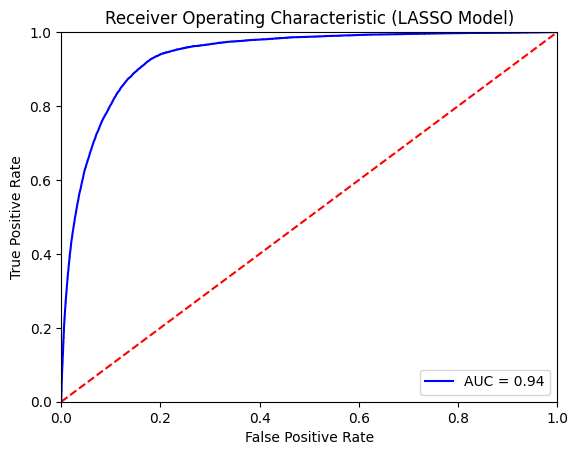

In [80]:
# Generate ROC curve
fpr_lasso, tpr_lasso, threshold_lasso = roc_curve(y_test_NoUpsam['y'], p_x_lasso_optimal)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

plt.title('Receiver Operating Characteristic (LASSO Model)')
plt.plot(fpr_lasso, tpr_lasso, 'b', label='AUC = %0.2f' % roc_auc_lasso)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


ROC Curve is the same as the previous 2 models. The model does an excellent job at distinguishing between the classes.

In [81]:
### Find the optimal classification threshold
# Calculate Youden's J statistic for each threshold
youden_j = tpr_lasso - fpr_lasso  ### Sensitivity - Specificity

# Find the optimal threshold (maximizing Youden's J)
optimal_idx = np.argmax(youden_j) ### Prints the index of the maximum value in the array
optimal_threshold = threshold[optimal_idx]

# Print results
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Youden's J Statistic: {youden_j[optimal_idx]}")

Optimal Threshold: 0.29979428814893666
Youden's J Statistic: 0.7465727326488187


Confusion Matrix Given Optimal Cuttoff Value:

In [82]:
# Predict probabilities using the best LASSO model
p_x_lasso_optimal = LogisticModel_Optimal_Fitted.predict_proba(X_test_NoUpsamp)[:, 1]

# Classify predictions based on a 0.5 cutoff
y_hat_lasso_optimal = (p_x_lasso_optimal > optimal_threshold)

# Create confusion matrix
conf_mat_lasso = pd.crosstab(y_test_NoUpsam['y'], y_hat_lasso_optimal, rownames=['Actual Subscriptions'], colnames=['Predicted Subscriptions'])

# Add row and column sums
conf_mat_lasso.loc['Column_Total'] = conf_mat_lasso.sum(numeric_only=True, axis=0)
conf_mat_lasso.loc[:, 'Row_Total'] = conf_mat_lasso.sum(numeric_only=True, axis=1)

print("\nConfusion Matrix (LASSO):")
print(conf_mat_lasso)


Confusion Matrix (LASSO):
Predicted Subscriptions   False   True  Row_Total
Actual Subscriptions                             
0                        109255  22570     131825
1                          1503  16672      18175
Column_Total             110758  39242     150000


In [83]:
### Confusion Matrix Key Metrics at 0.5 cuttoff
FN = 1503
FP = 22570
TN = 109255
TP = 16672
Tot_Positives = FN + TP
Tot_Negatives = FP + TN
N_Plus_P = Tot_Positives + Tot_Negatives

MCR = (FP + FN)/N_Plus_P
TPR = TP/Tot_Positives  ### Out of all positive cases (FN and TP), what % where accurately labeled positive
TNR = TN/Tot_Negatives
precision = TP/(TP + FP) ### Out of all cases labeled Positive (TP and FP) what % were accurately labeled positive

print(f"The Misclassified Rate is: {MCR * 100:.2f}%")
print(f"The True Positive Rate (Sensitivity or Recall) is: {TPR * 100:.2f}%")
print(f"The True Negative Rate (Specifity) is: {TNR * 100:.2f}%")
print(f"The Precision is: {precision * 100:.2f}%")

The Misclassified Rate is: 16.05%
The True Positive Rate (Sensitivity or Recall) is: 91.73%
The True Negative Rate (Specifity) is: 82.88%
The Precision is: 42.49%


### Final Notes:

Overall, I would say that the Lasso Logistic Regression on the Upsampled data should be the best choice out of the 3. At the 50% cuttoff point, Both Upsampled models outperformed the non-upsampled model with much better True Positive Rates (83.94% and 83.94% vs 51.80% in the non-upsampled model), very acceptable True Negative Rates given the decrease in precision (88.47% and 88.46% vs 97.09% in the non-upsampled model), and tolerable misclassifcation rates given the boost we get in recall (12.08% and  12.08% vs 8.39% in the non-upsampled model). I am choosing the Lasso model over the non-lasso model because of the ability to further improve its performance by tuning. For the sake of time and performance, I only performed 5 fold cross validation and only tested 20 values for the penalty term, so there is potential room for improvement given more testing. With further tuning, the Lasso model can be made even more generalized, and hense will perform better across a plethora of datasets.

### Prep For Kaggle Submission:

In [84]:
### Grab IDs from Kaggle Test Set
Kaggle_Test_IDs = Bank_DF_Test['id']

In [86]:
### Grab Prepped Data based on Kaggle Test Set
X_Scaled_DF_Final_KaggleTesting.head()

,balance,duration,campaign,pdays,previous,Age_DeMeaned,Age_DeMeaned_Sqrd,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,0.07,-0.12,-0.58,-0.30,-0.22,-0.89,-0.15,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,-0.43,1.22,-0.21,-0.30,-0.22,0.30,-0.65,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,-0.42,-0.53,-0.21,-0.30,-0.22,-0.49,-0.54,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,-0.94,-0.48,-0.58,-0.30,-0.22,1.69,1.33,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0.27,-0.27,-0.58,-0.30,-0.22,-1.28,0.46,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [87]:
# Predict probabilities using the best LASSO model
p_x_lasso_optimal = LogisticModel_Optimal_Fitted.predict_proba(X_Scaled_DF_Final_KaggleTesting)[:, 1]

In [88]:
#### Convert Probability Array to Dataframe
Prob_DF = pd.DataFrame(p_x_lasso_optimal).rename(columns = {0 : 'y'})
### Concatenate Ids to Probabilites
Final_Predictions = pd.concat([Kaggle_Test_IDs,Prob_DF], axis = 1)

In [103]:
### View subscription Predictions per user
Final_Predictions.head(10)

,id,y
0,750000,0.11
1,750001,0.98
2,750002,0.01
3,750003,0.01
4,750004,0.31
5,750005,0.05
6,750006,0.98
7,750007,0.97
8,750008,0.21
9,750009,0.98


#### Export CSV File

In [90]:
# File path
Final_Predictions.to_csv("kaggle_Submission.csv", index = False)